In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
# import libraries
# import cv2
import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
# import tensortools as tt
# import pywt
# import scaleogram as scg
import scipy
import scipy.signal
import pandas as pd

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import multiprocessing
from multiprocessing import Pool

import imageio

import pywavesurfer.ws

# import torch
# import torch.cuda

# import mtaper_specgram
# import test_function

In [3]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

In [4]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/face-rhythm/functions')

# import mtaper_specgram

In [5]:
# # sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON functions')
# import getVideoDirectoryProperties

In [6]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

coding_env


In [7]:
%matplotlib notebook

In [8]:
# ### find version of openCV
# # script currently works with v4.4.0
# (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
# print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# # print(cv2.getBuildInformation())

# ### find version of pytorch
# print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

Autodetected operating system: Windows. Using "\\" for directory slashes


In [9]:
## == IMPORT DATA ==

## import S2p data

dir_s2p = r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210410\exp\suite2p\plane0'

F = np.load(f'{dir_s2p}{slash_type}F.npy')
Fneu = np.load(f'{dir_s2p}{slash_type}Fneu.npy')
iscell = np.load(f'{dir_s2p}{slash_type}iscell.npy')
ops = np.load(f'{dir_s2p}{slash_type}ops.npy', allow_pickle=True)
spks = np.load(f'{dir_s2p}{slash_type}spks.npy')
stat = np.load(f'{dir_s2p}{slash_type}stat.npy', allow_pickle=True)

num_frames_S2p = F.shape[1]

In [45]:
## == IMPORT LOGGER DATA ==
import scipy.io

dir_logger = r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210410'
fileName_logger = 'logger_aligned.mat'
path_logger = f'{dir_logger}{slash_type}{fileName_logger}'
logger = scipy.io.loadmat(path_logger)['logger_aligned']

decoder_output = logger['decoder'][0][0][:,1] # 'cursor_brain_raw'
cursor_output = logger['decoder'][0][0][:,2] # 'cursor_output'


<IPython.core.display.Javascript object>


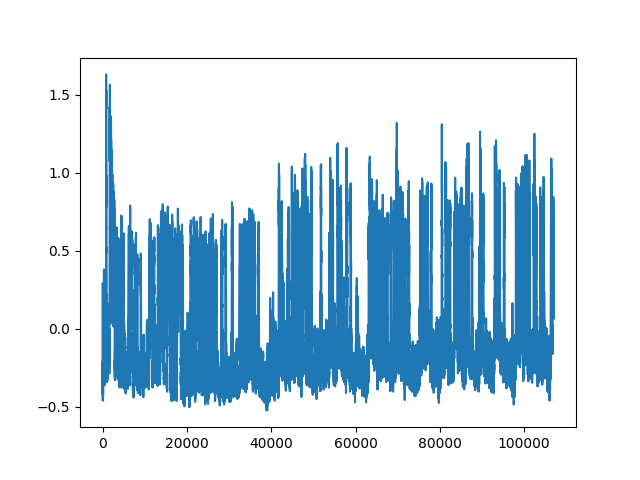

In [46]:
plt.figure()
plt.plot(decoder_output)
# plt.plot(cursor_output)

In [47]:
# ## == IMPORT DATA ==

# ## Import ROI Classifier data

# dir_ROIClassifier = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112/'

# IsCell_ROIClassifier = np.load(f'{dir_ROIClassifier}{slash_type}IsCell_ROIClassifier.npy')
# ROI_Classifier_manual_selection_vars = np.load(f'{dir_ROIClassifier}{slash_type}manual_selection_vars.npy', allow_pickle=True)


<IPython.core.display.Javascript object>


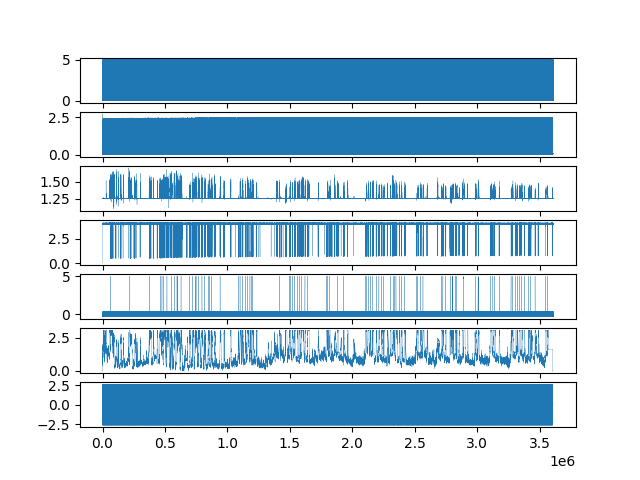

In [48]:
### import wavesurfer data

dir_ws = r'D:\RH_local\data\wavesurfer data\round 5 experiments\mouse 2_6\20210410'
fileName_ws = 'exp_0001.h5'

data_as_dict = pywavesurfer.ws.loadDataFile(filename=f'{dir_ws}{slash_type}{fileName_ws}', format_string='double' )
ws_data = data_as_dict[f'{list(data_as_dict.keys())[1]}']['analogScans']

fig = plt.figure()
for ii in range(ws_data.shape[0]):
    subplot_size = int(str(ws_data.shape[0]) + str(1) + str(ii+1))
    ax1 = fig.add_subplot(subplot_size)
    plt.plot(ws_data[ii,:] , linewidth=0.2)

<IPython.core.display.Javascript object>


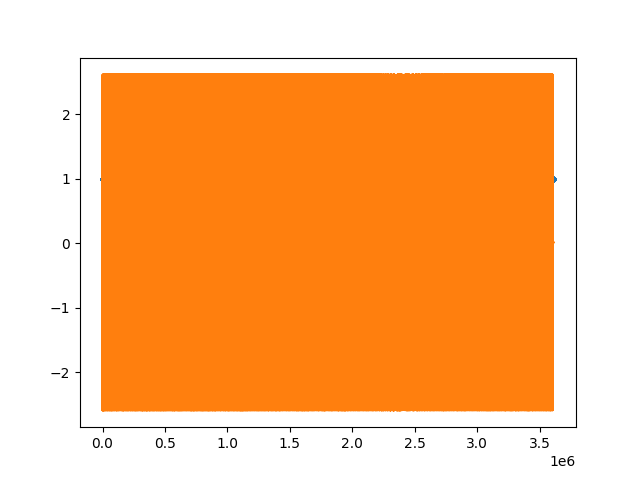

frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.36262962962963
total elapsed time: 0.13 seconds


In [49]:
## == ALIGN DATA ==

# Get ws frame times in ws time. Everything should be aligned to ws frame times (S2pInd)

# Outputs:
# - ws_YGalvoFlybacks_bool_wsTime
# - ws_frameTimes_wsTime   ***

tic = time.time()
ws_YGalvoFlybacks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[6,:]) < -1)) > 0.5

ws_frameTimes_wsTime = np.array(np.where(ws_YGalvoFlybacks_bool_wsTime))[0,:]
ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1]
# ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1][:-1]

plt.figure()
plt.plot(ws_frameTimes_wsTime,np.ones(len(ws_frameTimes_wsTime)),'.')
plt.plot(ws_data[6,:])
print(f'frames in scanimage movie = {num_frames_S2p}')
print(f'frames from ws galvo extraction movie = {ws_frameTimes_wsTime.shape[0]}')

ws_samples_per_S2p_frame_rough = (ws_frameTimes_wsTime[-1] - ws_frameTimes_wsTime[0]) / num_frames_S2p
print(f'number of wavesurfer samples per imaging frame:  {ws_samples_per_S2p_frame_rough}')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


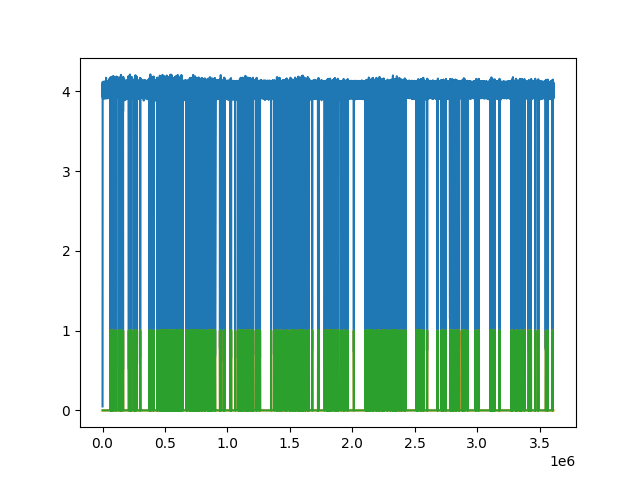

total elapsed time: 5.4 seconds


In [122]:
## Get lick times in S2p ind

# Outputs:
# - ws_licks_bool_wsTime
# - ws_licks_bool_S2pInd
# - ws_lickTimes_S2pInd   ***

tic = time.time()
ws_licks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[3,:]) < -0.2)) > 0.5

ws_licks_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_licks_bool_S2pInd[frame_num] = sum(ws_licks_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_lickTimes_S2pInd = np.array(np.where(ws_licks_bool_S2pInd))

plt.figure()
plt.plot(ws_data[3,:])
plt.plot(ws_licks_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_licks_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


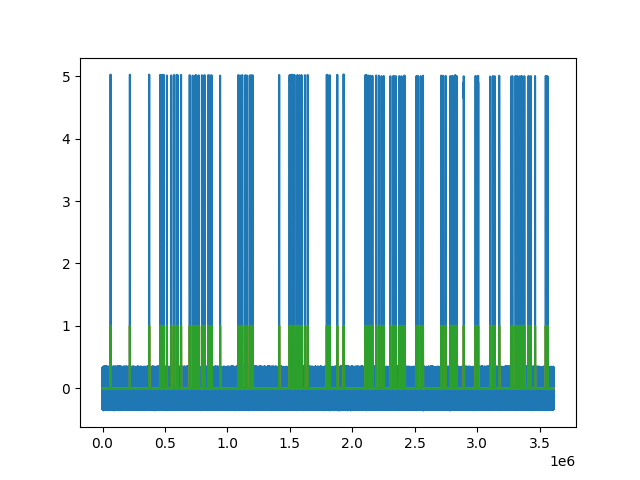

total elapsed time: 5.23 seconds


In [51]:
## Get reward delivery times in S2p ind

# Outputs:
# - ws_rewards_bool_wsTime
# - ws_rewards_bool_S2pInd
# - ws_rewardTimes_S2pInd   ***

tic = time.time()
ws_rewards_bool_wsTime = np.diff(np.int8(np.diff(ws_data[4,:]) > 1)) > 0.5


ws_rewards_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_rewards_bool_S2pInd[frame_num] = sum(ws_rewards_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_rewardTimes_S2pInd = np.array(np.where(ws_rewards_bool_S2pInd))

plt.figure()
plt.plot(ws_data[4,:])
plt.plot(ws_rewards_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_rewards_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [52]:
# np.double(ws_data[0,:].shape)/1000
# ws_data[0,int(987.5*1000):int(989*1000)]=0

<IPython.core.display.Javascript object>


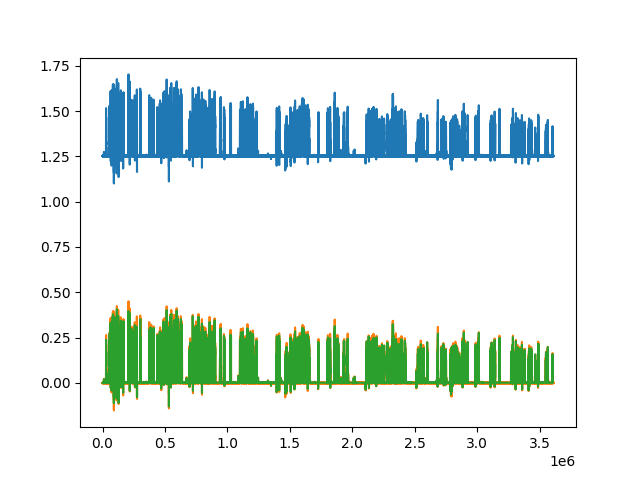

total elapsed time: 0.74 seconds


In [53]:
## Convert treadmill signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_treadmill_wsTime = ws_data[2,:] - np.percentile(ws_data[2,:], 20)

ws_treadmill_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_treadmill_S2pInd[frame_num] = sum(ws_treadmill_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_treadmill_S2pInd = ws_treadmill_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_treadmill_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_treadmill_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


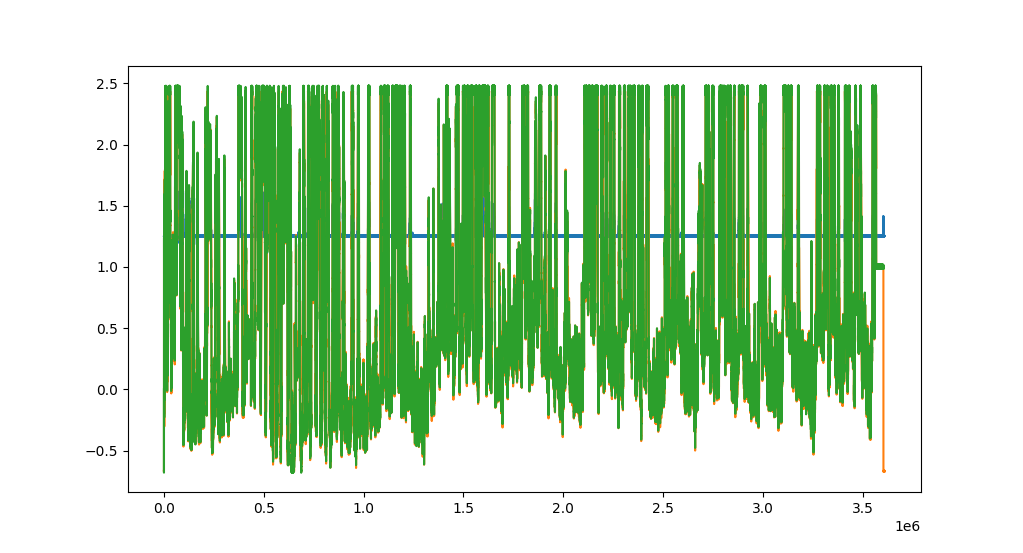

total elapsed time: 0.75 seconds


In [54]:
## Convert cursor voltage signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_cursorVoltage_wsTime = ws_data[5,:] - np.percentile(ws_data[5,:], 20)

ws_cursorVoltage_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_cursorVoltage_S2pInd[frame_num] = sum(ws_cursorVoltage_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_cursorVoltage_S2pInd = ws_cursorVoltage_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_cursorVoltage_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_cursorVoltage_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


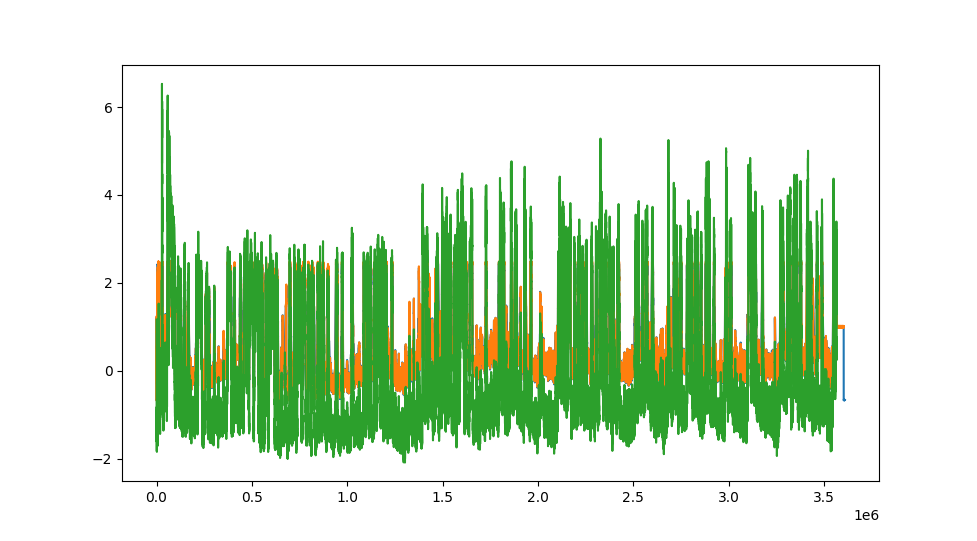

In [58]:
# Check alignment of logger and ws and S2p

plt.figure()
plt.plot(ws_cursorVoltage_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_cursorVoltage_S2pInd)
plt.plot(ws_frameTimes_wsTime, decoder_output*4)

In [59]:
### Make dFoF and zscored stuff
tic = time.time()
# F_neuSub = F - 0.7*Fneu
# F_baseline_static = np.percentile(F_neuSub,30)
# dF = F_neuSub - F_baseline_static
# dFoF = dF / F_baseline_static

F_baseline_static = np.percentile(F,30)
dF = F - F_baseline_static
dFoF = dF / F_baseline_static

F_zscore = scipy.stats.zscore(F, axis=1)
# spks_zscore = scipy.stats.zscore(spks, axis=1)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

total elapsed time: 5.48 seconds


In [61]:
## Make rolling baseline subtraction
# sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
# import welford_moving_2D
from bmi_idap.helpers import welford_moving_2D
import tqdm
from tqdm import trange

# list_of_values = [3, 5, 8, 10, 4, 8, 12, 15, 11, 9]
F_mean_rolling = np.ones_like(F.T) * np.nan
F_var_rolling = np.ones_like(F.T) * np.nan
win_size_rollingBaseline = round(60 * 30 * 10)
list_of_values = F.T
varSum_old = None
mean_old = None
for idx in trange(len(list_of_values)):

    mean_new = welford_moving_2D.update_mean(idx, list_of_values, win_size_rollingBaseline, mean_old)
    varSum_new = welford_moving_2D.update_varSum(idx, list_of_values, win_size_rollingBaseline, varSum_old)
    var_new = welford_moving_2D.varSum_to_var(idx, list_of_values, win_size_rollingBaseline, mean_new, varSum_new)

    F_mean_rolling[idx,:] = mean_new
    F_var_rolling[idx,:] = var_new
#     msg = "SMA=%.4f, PSA=%.4f, Var=%.4f" % (mean_new, varSum_new, var_new)
#     print("bar %i: %s" % (idx, msg))

    mean_old = mean_new
    varSum_old = varSum_new

eps = 1e-7
F_var_rolling[F_var_rolling<eps] = eps
F_zscore_roll = (list_of_values - F_mean_rolling)/np.sqrt(F_var_rolling)

100%|████████████████████████████████████████████████████████████████████████| 108000/108000 [01:15<00:00, 1430.64it/s]


In [62]:
## check to see if any of the traces are bad
# check if any traces are all NaNs
all_nan_traces = np.where( np.sum(np.isnan(F_zscore_roll) , axis=0) == F_zscore_roll.shape[0] )[0]
print(f'the following ROI #s are all NaNs: {all_nan_traces}')
any_nan_traces = np.where( np.sum(np.isnan(F_zscore_roll) , axis=0) > 0 )[0]
print(f'the following ROI #s have at least one NaN: {any_nan_traces}')
any_inf_traces = np.where( np.sum(F_zscore_roll==np.inf , axis=0) > 0 )[0]
print(f'the following ROI #s have at least one inf: {any_inf_traces}')
any_negInf_traces = np.where( np.sum(F_zscore_roll==-np.inf , axis=0) > 0 )[0]
print(f'the following ROI #s have at least one inf: {any_negInf_traces}')
all_0_traces = np.where( np.sum(F_zscore_roll==0 , axis=0) == F_zscore_roll.shape[0] )[0]
print(f'the following ROI #s are all 0s: {all_0_traces}')

the following ROI #s are all NaNs: []
the following ROI #s have at least one NaN: []
the following ROI #s have at least one inf: []
the following ROI #s have at least one inf: []
the following ROI #s are all 0s: []


<IPython.core.display.Javascript object>


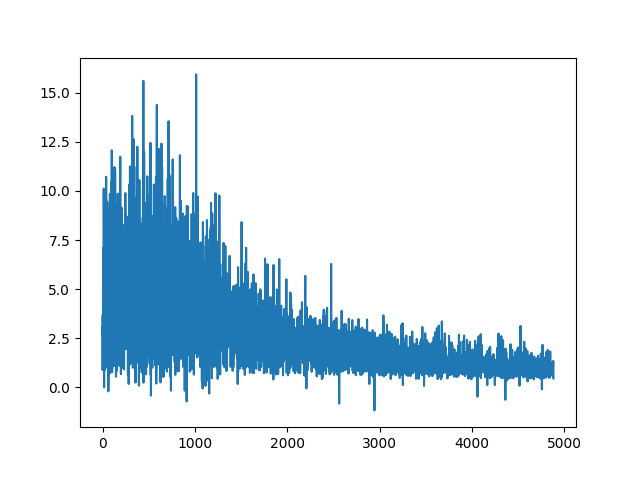

In [63]:
### Subselect good ROIs
n_roi = len(stat)
skew_all = np.zeros(n_roi) * np.nan
for ii in range(n_roi):
    skew_all[ii] = stat[ii]['skew']

plt.figure()
plt.plot(skew_all)

In [66]:
## Import ROI Classifier data

dir_ROIClassifier = r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210411\analysis_lastNight'

IsCell_ROIClassifier = np.load(f'{dir_ROIClassifier}{slash_type}IsCell_ROIClassifier.npy')
ROI_Classifier_manual_selection_vars = np.load(f'{dir_ROIClassifier}{slash_type}manual_selection_vars.npy', allow_pickle=True)

is_cell_new = IsCell_ROIClassifier

<IPython.core.display.Javascript object>


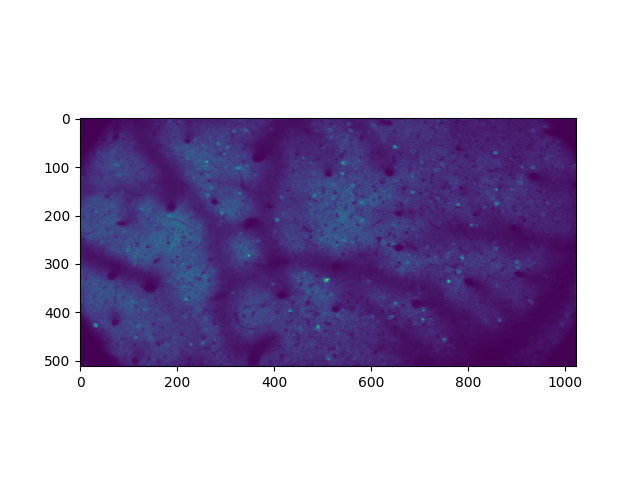

<IPython.core.display.Javascript object>


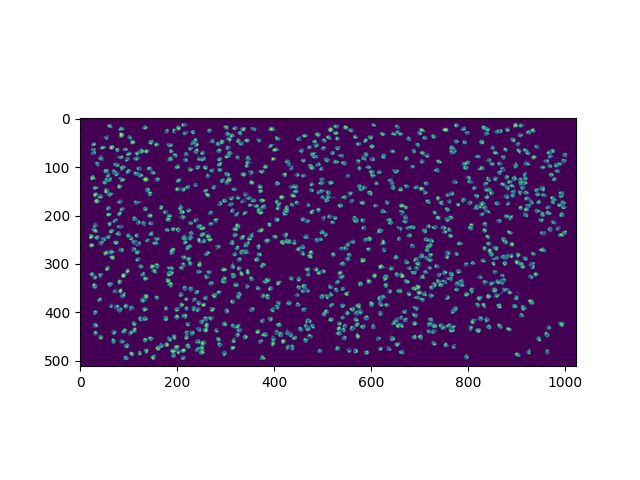

<IPython.core.display.Javascript object>


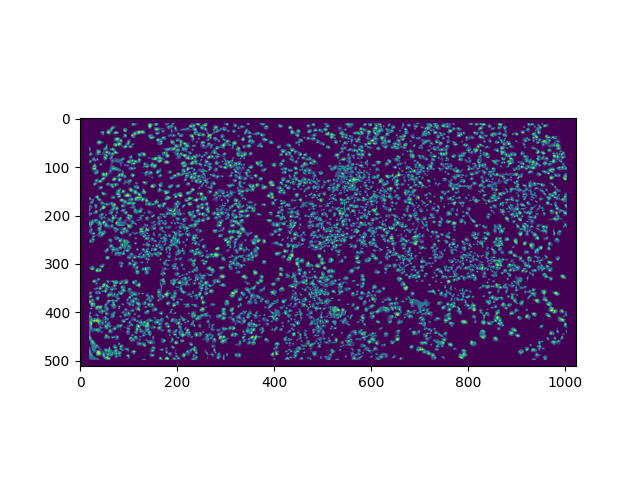

<IPython.core.display.Javascript object>


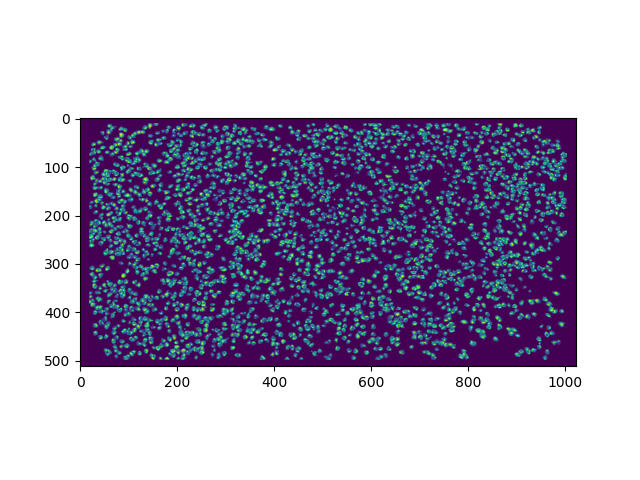

In [68]:
%matplotlib notebook

meanImg = ops[()]['meanImg']
frame_height = meanImg.shape[0]
frame_width = meanImg.shape[1]

plt.figure()
plt.imshow(meanImg)

masks_all_flat = np.zeros_like(meanImg)
S2p_masks_all_flat = np.zeros_like(meanImg)
masks_all_unselected_flat = np.zeros_like(meanImg)
for ii in range(len(stat[()])):
    if is_cell_new[ii]==1:
#     if iscell[ii,0]:
        masks_all_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
    else:
        masks_all_unselected_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
    if iscell[ii,0]==1:
        S2p_masks_all_flat[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

plt.figure()
plt.imshow(masks_all_flat**1)
plt.figure()
plt.imshow(masks_all_unselected_flat**1)
plt.figure()
plt.imshow(S2p_masks_all_flat)

In [402]:
## == Dim reduction ==

<IPython.core.display.Javascript object>


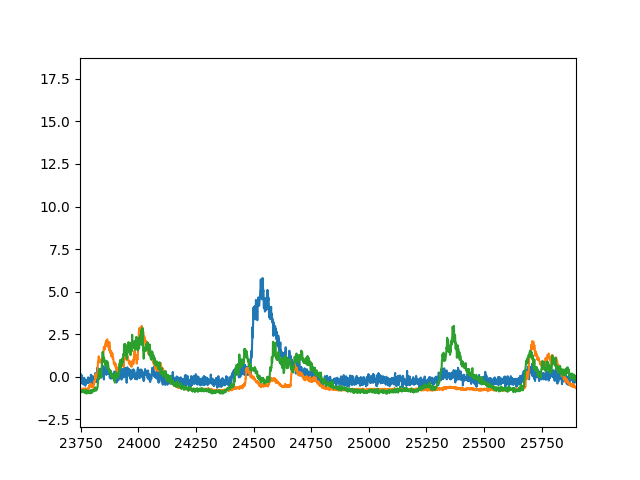

In [84]:
plt.figure()
plt.plot(F_zscore_roll[:,np.where(is_cell_new)[0][10:13]])

<IPython.core.display.Javascript object>


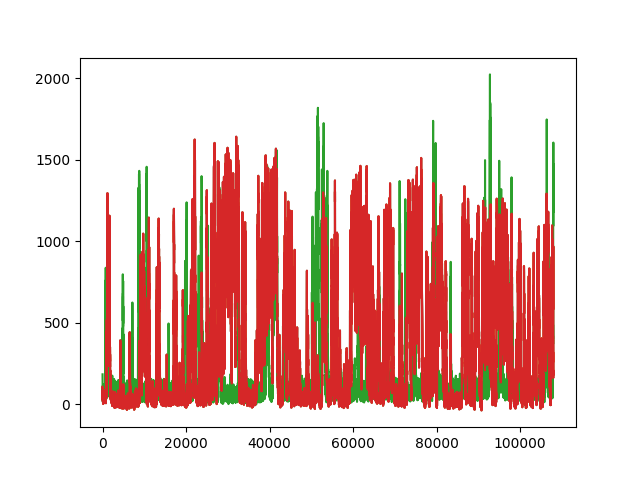

In [71]:
plt.figure()
plt.plot(dF[is_cell_new,:].T[:,:4])

<IPython.core.display.Javascript object>


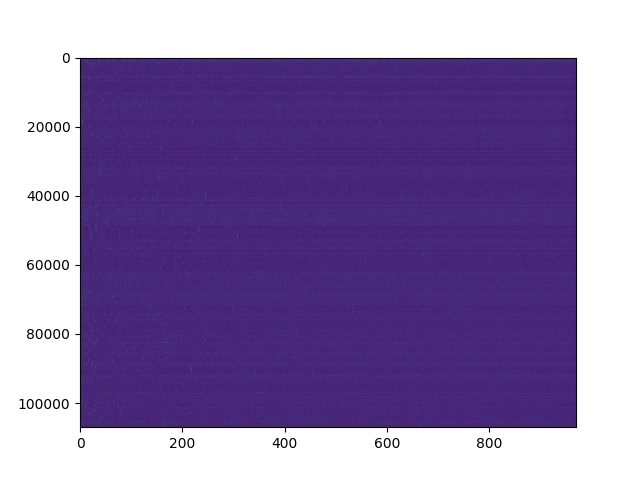

In [87]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
plt.figure()
plt.imshow(F_zscore_roll[1000:,np.where(is_cell_new)[0]] , aspect='auto',)

In [24]:
## == REGRESSION ANALYSIS

(108000, 971)


<IPython.core.display.Javascript object>


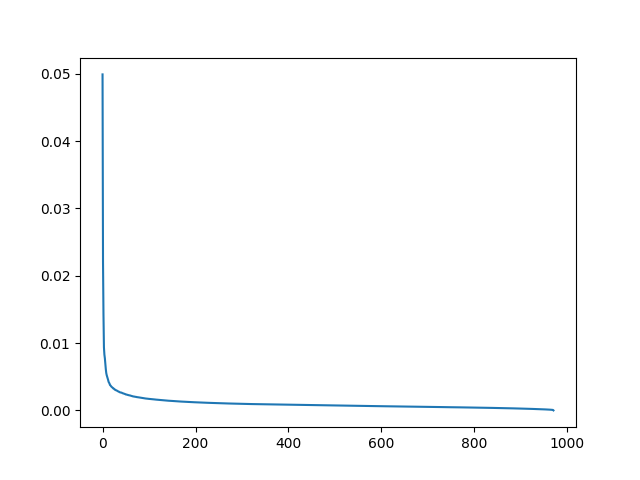

In [90]:
input_dimRed = F_zscore_roll[:,is_cell_new==True]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

print(output_PCA.shape)
plt.figure()
plt.plot(pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


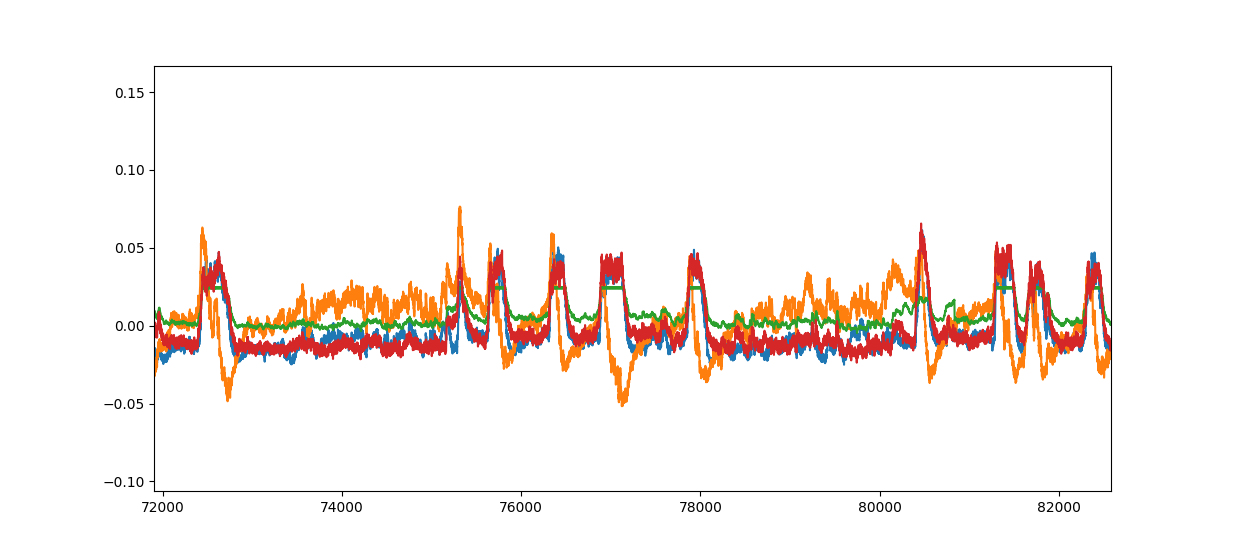

In [95]:
plt.figure()
plt.plot(-output_PCA[:,:2]*6)
plt.plot(ws_cursorVoltage_S2pInd/100)
plt.plot(decoder_output/20)

In [23]:
### REGRESSION

In [111]:
# import sklearn.linear_model
L1_alpha = 10**(-2.5)

# X_input = dFoF[IsCell_ROIClassifier==True,:].T
# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)

y_input = copy.deepcopy(decoder_output)
y_input[np.isnan(y_input)] = np.nanmean(y_input)
# y_input = np.hstack((y_input[5:] , np.zeros(5)))


X = np.hstack((np.ones(X_input.shape[0])[:,None] , X_input))

y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

### SKLEARN regression
clf = sklearn.linear_model.Lasso(alpha=L1_alpha)
clf.fit(X_train , y_train )
theta = clf.coef_

#     theta = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'train R: {R_train}')

y_test_output = X_test @ theta
R_test = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'test  R: {R_test} , test  R^2: {R_test**2}')

y_reconstructed = X @ theta
#     y_reconstructed = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input)) @ theta
#     y_reconstructed = np.hstack((np.ones(F_zscore_roll.shape[0]).reshape(F_zscore_roll.shape[0],1) , F_zscore_roll)) @ theta

train R: 0.9897908017957461
test  R: 0.9897618510775552 , test  R^2: 0.9796285218484686


<IPython.core.display.Javascript object>


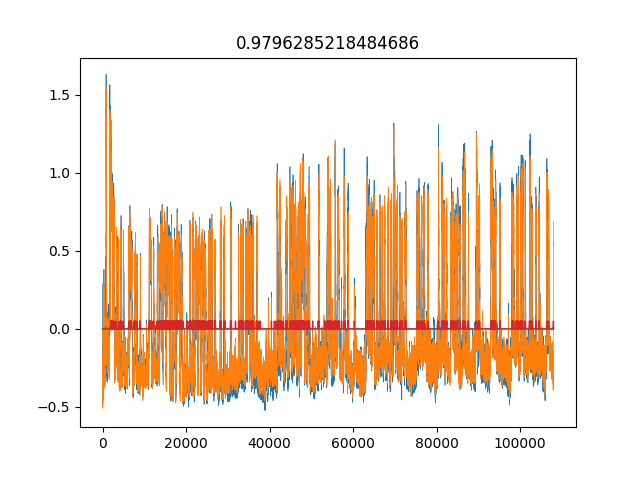

Text(0.5, 1.0, '0.9796285218484686')

In [112]:
y_reconstructed = X @ theta
# weights_RegressionAnalysisOutput
plt.figure()

plt.plot(y_input , linewidth=0.5)
plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(ws_treadmill_S2pInd / 20 , linewidth=1.0)
plt.plot(ws_licks_bool_S2pInd / 20 , linewidth=1.0)
plt.title(R_test**2)

<IPython.core.display.Javascript object>


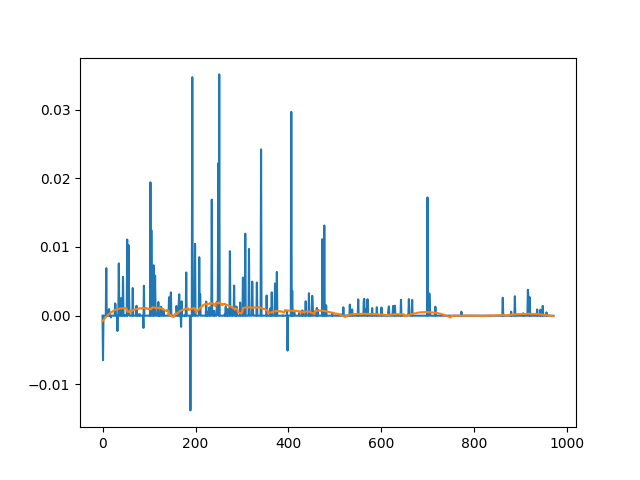

Number of non-zero coefficients: 157
Number of zero coefficients: 814


In [113]:
plt.figure()
plt.plot(theta[1:])
plt.plot(scipy.signal.savgol_filter(theta[1:] , 101 , 3))
print(f'Number of non-zero coefficients: {np.sum(theta[1:]!=0)}')
print(f'Number of zero coefficients: {np.sum(theta[1:]==0)}')

<IPython.core.display.Javascript object>


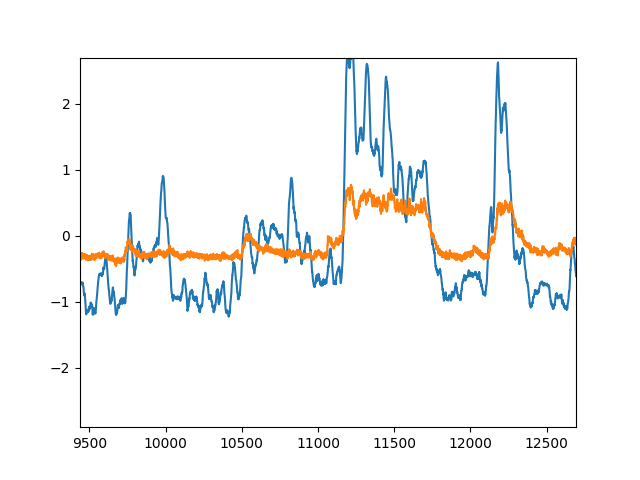

<IPython.core.display.Javascript object>


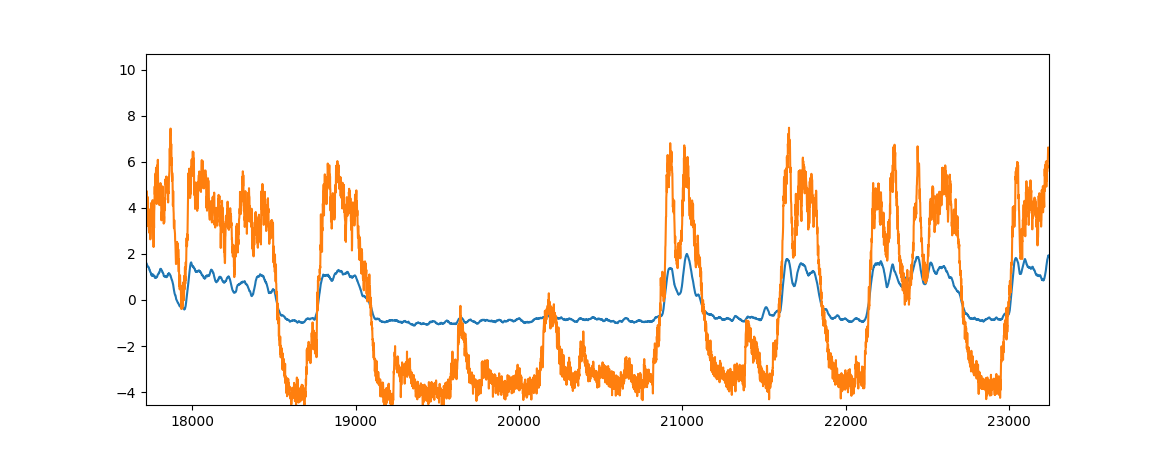

In [114]:
##plot the lowest and highest signal cells to be included
theta_tmp = copy.deepcopy(theta)
theta_tmp[theta_tmp==0] = 1*np.nan
plt.figure()
plt.plot(scipy.signal.savgol_filter(F_zscore_roll[:,
    np.where(is_cell_new)[0][np.where(theta[1:]==np.nanmin(np.abs(theta_tmp[1:])))[0][0]]] ,51,3))
plt.plot(y_reconstructed)

plt.figure()
plt.plot(scipy.signal.savgol_filter(F_zscore_roll[:,
    np.where(is_cell_new)[0][np.where(theta[1:]==np.nanmax(np.abs(theta_tmp[1:])))[0][0]]] ,51,3))
plt.plot(y_reconstructed*10)

treadmill, train R: 0.8943988378236707
treadmill, test  R: 0.8877186305346662
R^2: 0.7880443669983431


<IPython.core.display.Javascript object>


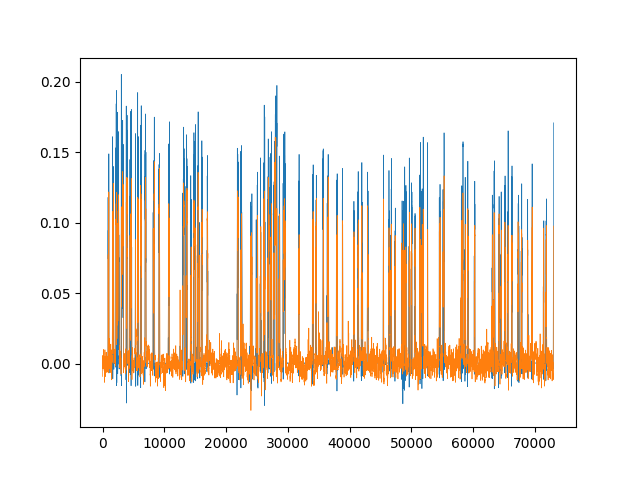

In [115]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,is_cell_new==True]
X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd[idx_nonRunning] , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

treadmill, train R: 0.758265226730529
treadmill, test  R: 0.7567143126370468


<IPython.core.display.Javascript object>


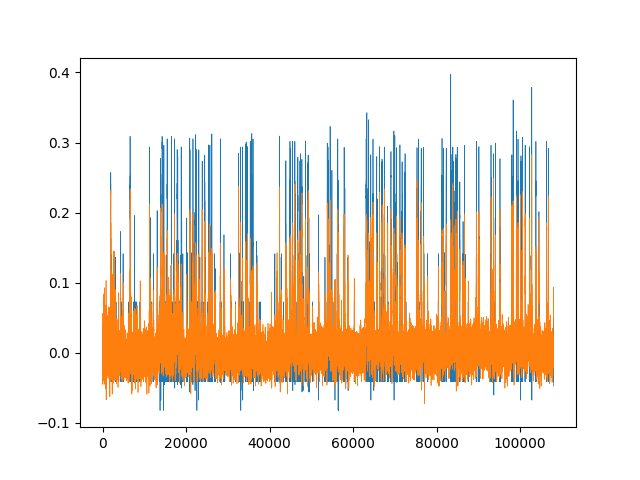

In [116]:
## Correlate to licking signal
idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
idx_nonRunning[:20000] = 0
idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,is_cell_new==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
plt.plot(y_reconstructed , linewidth=0.5)
# plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

In [119]:
## Saving output ensembles
import scipy.io

weights_RegressionAnalysisOutput = theta[1:]

regression_output = {"regression_goalSignal": y_input,
                     "regression_reconstruction": y_reconstructed,
                     "refit_identity": 'decoder_output'
                    }

weights_dayN = {
    "weights": weights_RegressionAnalysisOutput,
    "iscell_custom": is_cell_new,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "regression_output":regression_output,
    "R_test": R_test,
    "L1_alpha": L1_alpha,
}

dir_save = r'D:\RH_local\data\scanimage data\round 5 experiments\mouse 2_6\20210411\analysis_lastNight'
save_name = 'weights_dayN'
save_fullPath = f'{dir_save}{slash_type}weights_dayN'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_dayN)

np.save(f'{save_fullPath}.npy' , weights_dayN)

<IPython.core.display.Javascript object>


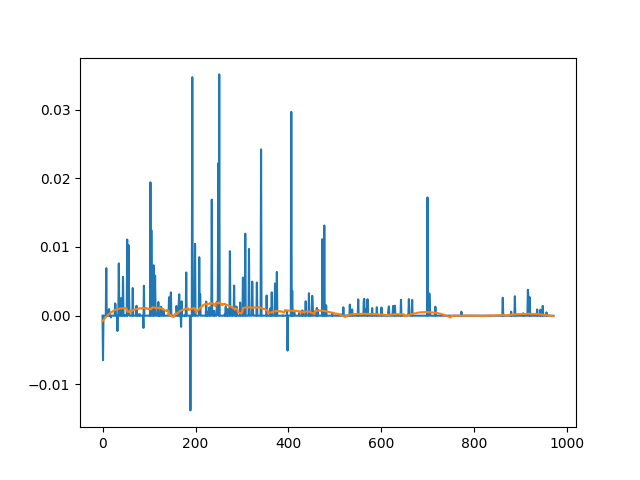

In [120]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3))

<IPython.core.display.Javascript object>


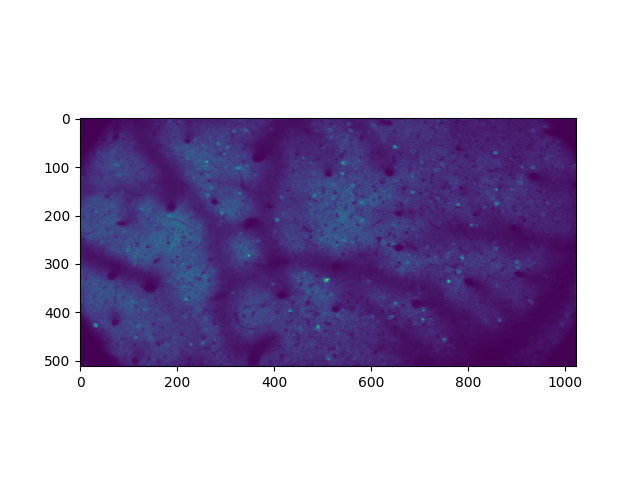

<IPython.core.display.Javascript object>


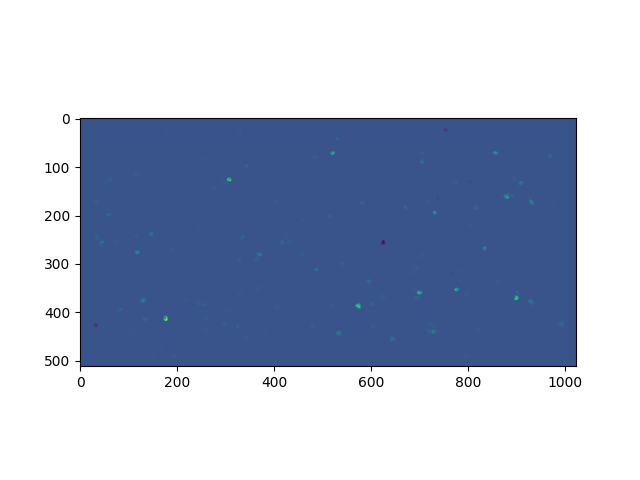

In [121]:
%matplotlib notebook

meanImg = ops[()]['meanImg']
frame_height = meanImg.shape[0]
frame_width = meanImg.shape[1]

plt.figure()
plt.imshow(meanImg)

cc=0
masks_all_flat_weighted = np.zeros_like(meanImg)
# masks_all_flat_weighted2 = np.zeros_like(meanImg)
for ii in range(len(stat[()])):
    if weights_dayN['iscell_custom'][ii]==1:
#         print(ii)
        masks_all_flat_weighted[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] * weights_dayN['weights'][cc]
#         masks_all_flat_weighted2[stat[()][ii]['ypix'] , stat[()][ii]['xpix']] = stat[()][ii]['lam'] * theta[cc+1]

        cc+=1

plt.figure()
plt.imshow(masks_all_flat_weighted)
# plt.figure()
# plt.imshow(masks_all_flat_weighted2)
